# 3. 멋진 단어사전 만들기 [프로젝트]
<br>

## 3-1. 프로젝트: SentencePiece 사용하기
<br>

#### 사용할 라이브러리 버전 확인
<br>

In [40]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


<br><br>

### Step 1. SentencePiece 설치하기
<br>

In [41]:
# $ pip install sentencepiece

<br><br>

### Step 2. SentencePiece 모델 학습
<br>

####  데이터 다운로드 및 확인
<br>

In [42]:
# 데이터 다운로드

In [43]:
# wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
# mkdir -p ~/aiffel/sp_tokenizer/data
# mv korean-english-park.train.tar.gz ~/aiffel/sp_tokenizer/data
# cd ~/aiffel/sp_tokenizer/data
# tar -xzvf korean-english-park.train.tar.gz

<br>

In [44]:
# 데이터 확인

In [45]:
import os

path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

In [46]:
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

In [47]:
print("Data Size:", len(raw))

Data Size: 94123


In [48]:
print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


<br>

#### 데이터 분석
<br>

In [49]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

In [50]:
print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


<br>

In [51]:
sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

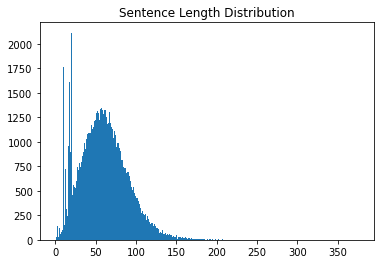

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

<br>

In [53]:
# 길이가 1인 문장 확인

In [54]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

In [55]:
check_sentence_with_length(raw, 1)

’


<br>

In [56]:
# 문장의 수가 1500을 초과하는 문장 길이 추출

In [57]:
for idx, _sum in enumerate(sentence_length):
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


<br>

#### 데이터 전처리
<br>

In [58]:
# 중복된 요소 제거 (python 기본 자료형 set활용)

In [59]:
cleaned_corpus = list(set(raw))  
print("Data Size:", len(cleaned_corpus))

Data Size: 77591


<br>

In [60]:
min_len = 999
max_len = 0
sum_len = 0

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

In [61]:
print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


<br>

In [62]:
sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

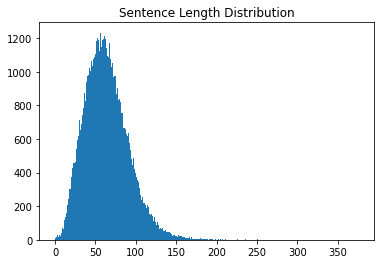

In [63]:
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

<br>

In [64]:
# 1) 길이가 150 이상의 데이터 제거 (큰 메모리 차지, 학습 시간 오래 걸림)
# 2) 길이가 10 미만인 데이터 제거 (너무 짧은 데이터는 오히려 노이즈로 작용)

In [65]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택함.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

<br>

In [66]:
# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

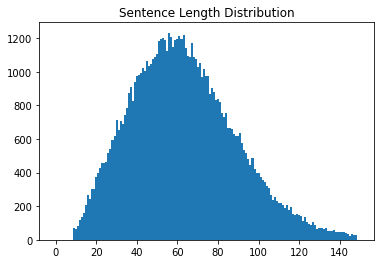

In [67]:
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

<br>

#### SentencePiece 모델 학습
<br>

In [68]:
# tokenize() 함수
# 토크나이저 내부적으로 단어사전과 토크나이저기 능을 corpus에 맞춤형으로 자동 생성해줌.

In [69]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

<br>

In [70]:
# 이를 위해서 SentencePiece 모델을 학습하는 과정을 거쳐야 합니다.

In [71]:
# 데이터 확인

In [72]:
import sentencepiece as spm
import os

In [73]:
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

In [74]:
with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

<br>

In [75]:
vocab_size = 8000

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

In [76]:
# 위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. 
# --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

<br>

In [77]:
!ls -l korean_spm*

-rw-r--r-- 1 root root 376816 Aug 16 07:50 korean_spm.model
-rw-r--r-- 1 root root 146213 Aug 16 07:50 korean_spm.vocab


In [78]:
# 위 코드를 실행하면 정상적으로 SentencePiece 모델 학습이 완료된 후
# korean_spm.model 파일과 korean_spm.vocab vocabulary 파일이 생성됨을 확인할 수 있음.

<br>

#### 학습된 SentencePiece 모델 활용 확인
<br>

In [79]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

True

<br>

In [80]:
# SentencePiece를 활용한 sentence -> encoding

In [81]:
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]


<br>

In [82]:
# SentencePiece를 활용한 sentence -> encoded pieces

In [83]:
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']


<br>

In [84]:
# SentencePiece를 활용한 encoding -> sentence 복원

In [85]:
print(s.DecodeIds(tokensIDs))

아버지가방에들어가신다.


<br>

In [86]:
# SentencePiece의 토크나이징 실력이 나쁘지 않음을 확인

<br><br>

### Step 3. Tokenizer 함수 작성
<br>

#### 위에서 훈련시킨 SentencePiece를 활용하여 sp_tokenize() 함수를 정의할 것입니다.

<br>

In [87]:
# 1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.
# 2. 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과
#    <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.
# 3. 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 
#   (바로 학습에 사용할 수 있게 Padding)

In [88]:
def sp_tokenize(s, corpus): 
    tensor = []
    
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))
        
    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()
        
    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})
        
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, word_index, index_word

<br><br>

### Step 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기
<br>

#### 1) 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
<br>

##### 데이터 준비와 확인
<br>

In [89]:
# 데이터셋: 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus
# 데이터 다운로드 없이 Cloud shell에서 해당 파일의 심볼릭 링크를 연결
# $ ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

In [90]:
import pandas as pd

train_data = pd.read_table('./data/ratings_train.txt')

In [91]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


<br>

In [92]:
path_to_file = './data/ratings_train.txt'
num_lines_to_read = 5

In [93]:
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

In [94]:
print("Data Size:", len(raw))

Data Size: 150001


In [95]:
print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Example:
>> id	document	label
>> 3989148	약탈자를 위한 변명, 이라. 저놈들은 착한놈들 절대 아닌걸요.	1
>> 4805788	이 영화가 왜 이렇게 저평가 받는지 모르겠다	1
>> 8317483	백봉기 언제나오나요?	1
>> 9801316	아햏햏 아햏햏 아햏햏.	1


In [96]:
with open(path_to_file, 'r', encoding='utf-8') as file:
    lines_preview = [file.readline().strip() for _ in range(num_lines_to_read)]

lines_preview

['id\tdocument\tlabel',
 '9976970\t아 더빙.. 진짜 짜증나네요 목소리\t0',
 '3819312\t흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나\t1',
 '10265843\t너무재밓었다그래서보는것을추천한다\t0',
 '9045019\t교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정\t0']

In [97]:
sentences = []
with open(path_to_file, 'r', encoding='utf-8') as file:
    next(file)  # Skip the header line
    for line in file:
        parts = line.strip().split('\t')
        if len(parts) > 1:  # Ensure that the line has the required parts
            sentences.append(parts[1])

In [98]:
print("Example:")
for sen in sentences[0:100][::20]:
    print(">>", sen)

Example:
>> 아 더빙.. 진짜 짜증나네요 목소리
>> 나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님
>> 단순하면서 은은한 매력의 영화
>> 보는내내 그대로 들어맞는 예측 카리스마 없는 악역
>> 뭐냐..시작하고 3분만에 나왔다. 리플릿 사진 보며 불안하더니만..


<br><br>

##### 데이터 분석
<br>

In [114]:
cleaned_corpus = list(set(raw))  
print("Data Size:", len(cleaned_corpus))

Data Size: 150001


In [115]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

In [116]:
print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

문장의 최단 길이: 8
문장의 최장 길이: 168
문장의 평균 길이: 45


<br>

In [117]:
sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

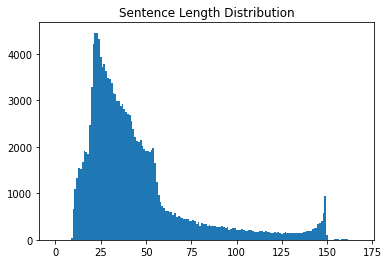

In [118]:
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

<br>

In [119]:
# 1) 길이가 150 이상의 데이터 제거 (큰 메모리 차지, 학습 시간 오래 걸림)
# 2) 길이가 10 미만인 데이터 제거 (너무 짧은 데이터는 오히려 노이즈로 작용)

In [123]:
max_len = 120
min_len = 10

# 길이 조건에 맞는 문장만 선택함.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

<br>

In [124]:
# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

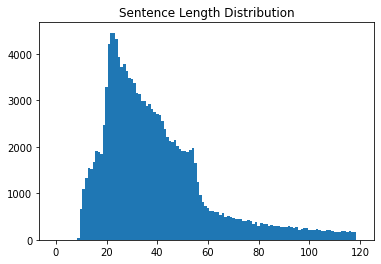

In [125]:
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

<br>

##### SentencePiece를 적용시킨 모델 학습
<br>

In [126]:
# tokenize() 함수
# 토크나이저 내부적으로 단어사전과 토크나이저 기능을 corpus에 맞춤형으로 자동 생성해줌.

In [127]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

<br>

In [108]:
# 이를 위해서 SentencePiece 모델을 학습하는 과정을 거쳐야 합니다.

In [109]:
# 데이터 확인

In [128]:
import sentencepiece as spm
import os

In [129]:
temp_file = './data/ratings_train_temp.txt'

In [130]:
with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

<br>

In [131]:
vocab_size = 8000

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=./data/ratings_train_temp.txt --model_prefix=naver_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./data/ratings_train_temp.txt
  input_format: 
  model_prefix: naver_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>

<br>

In [132]:
!ls -l naver_spm*

-rw-r--r-- 1 root root 447980 Aug 16 05:45 naver_spm_bpe_12000.model
-rw-r--r-- 1 root root 187220 Aug 16 05:45 naver_spm_bpe_12000.vocab
-rw-r--r-- 1 root root 525321 Aug 16 05:33 naver_spm_bpe_16000.model
-rw-r--r-- 1 root root 260561 Aug 16 05:33 naver_spm_bpe_16000.vocab
-rw-r--r-- 1 root root 298727 Aug 16 05:37 naver_spm_bpe_4000.model
-rw-r--r-- 1 root root  51971 Aug 16 05:37 naver_spm_bpe_4000.vocab
-rw-r--r-- 1 root root 371898 Aug 16 05:37 naver_spm_bpe_8000.model
-rw-r--r-- 1 root root 117142 Aug 16 05:37 naver_spm_bpe_8000.vocab
-rw-r--r-- 1 root root 253305 Aug 16 05:33 naver_spm_char_16000.model
-rw-r--r-- 1 root root  16825 Aug 16 05:33 naver_spm_char_16000.vocab
-rw-r--r-- 1 root root 253304 Aug 16 05:33 naver_spm_char_4000.model
-rw-r--r-- 1 root root  16825 Aug 16 05:33 naver_spm_char_4000.vocab
-rw-r--r-- 1 root root 253304 Aug 16 05:33 naver_spm_char_8000.model
-rw-r--r-- 1 root root  16825 Aug 16 05:33 naver_spm_char_8000.vocab
-rw-r--r-- 1 root root 368268 Aug 16

In [77]:
# 위 코드를 실행하면 정상적으로 SentencePiece 모델 학습이 완료된 후
# naver_spm.model 파일과 naver_spm.vocab vocabulary 파일이 생성됨을 확인할 수 있음.

<br>

##### 학습된 SentencePiece 모델 활용 확인
<br>

In [78]:
s = spm.SentencePieceProcessor()
s.Load('naver_spm.model')

True

<br>

In [79]:
# SentencePiece를 활용한 sentence -> encoding

In [133]:
tokensIDs = s.EncodeAsIds('그영화는우리에게많은감동을주었다.')
print(tokensIDs)

[43, 2766, 10, 1567, 68, 5758, 382, 356, 5, 75, 266, 3]


<br>

In [81]:
# SentencePiece를 활용한 sentence -> encoded pieces

In [134]:
print(s.SampleEncodeAsPieces('그영화는우리에게많은감동을주었다.',1, 0.0))

['▁그', '영화', '는', '우리', '에게', '많은', '감', '동', '을', '주', '었다', '.']


<br>

In [83]:
# SentencePiece를 활용한 encoding -> sentence 복원

In [135]:
print(s.DecodeIds(tokensIDs))

그영화는우리에게많은감동을주었다.


<br><br>

#### 2) 학습된 모델로 sp_tokenize() 메소드 구현하기
<br>

In [136]:
def sp_tokenize(s, corpus): 
    tensor = []
    
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))
        
    with open("./naver_spm.vocab", 'r') as f:
        vocab = f.readlines()
        
    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})
        
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, word_index, index_word

<br><br>

#### 3) 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
<br>

In [137]:
tensor, word_index, index_word = sp_tokenize(s, filtered_corpus)

In [138]:
print(tensor)
print(word_index)
print(index_word)

[[ 801  440 1150 ...    0    0    0]
 [ 121  281 2544 ...    0    0    0]
 [ 223 5123 4113 ...    0    0    0]
 ...
 [1067  440 2576 ...    0    0    0]
 [5261  440 3648 ...    0    0    0]
 [  99 3519 4388 ...    0    0    0]]
{'<unk>': 0, '<s>': 1, '</s>': 2, '▁': 3, '▁1': 4, '▁0': 5, '.': 6, '▁9': 7, '..': 8, '이': 9, '▁영화': 10, '▁8': 11, '...': 12, '가': 13, '의': 14, '도': 15, '▁7': 16, '는': 17, ',': 18, '을': 19, '▁6': 20, '고': 21, '에': 22, '▁5': 23, '은': 24, '▁10': 25, '다': 26, '지': 27, '▁3': 28, '▁4': 29, '?': 30, '한': 31, '▁2': 32, '▁너무': 33, '!': 34, '를': 35, '▁정말': 36, '만': 37, '▁이': 38, '로': 39, '게': 40, '나': 41, '영화': 42, '~': 43, '▁진짜': 44, '어': 45, '과': 46, '기': 47, '리': 48, '라': 49, '네': 50, '점': 51, '아': 52, '하고': 53, '인': 54, '으로': 55, '▁잘': 56, '▁안': 57, '....': 58, '!!': 59, '▁그': 60, '에서': 61, '▁아': 62, '▁왜': 63, '해': 64, '와': 65, '들': 66, '서': 67, '네요': 68, '▁이런': 69, '▁다': 70, '▁더': 71, '요': 72, '자': 73, '스': 74, '▁수': 75, '하는': 76, '음': 77, '▁본': 78, '▁그냥': 79, '거': 

<br><br>

#### 4) KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
<br>

##### KoNLPy 형태소 분석기
<br>

In [88]:
from konlpy.tag import Hannanum,Kkma,Komoran,Mecab,Okt

In [89]:
tokenizer_list = [Hannanum(),Kkma(),Komoran(),Mecab(),Okt()]

In [90]:
text = 'Google에서 제공하는 학습된 SentencePiece 모델의 토크나이저와 KoNLPy 형태소 분석기를 사용한 모델 중 어떤 게 더 성능이 좋은지 비교해봅시다.'

In [91]:
for tokenizer in tokenizer_list:
    print('[{}] \n{}'.format(tokenizer.__class__.__name__, tokenizer.pos(text)))

[Hannanum] 
[('Google', 'F'), ('에서', 'J'), ('제공', 'N'), ('하', 'X'), ('는', 'E'), ('학습', 'N'), ('되', 'X'), ('ㄴ', 'E'), ('SentencePiece', 'F'), ('모델', 'N'), ('의', 'J'), ('토크나이저', 'N'), ('와', 'J'), ('KoNLPy', 'F'), ('형태소', 'N'), ('분석기', 'N'), ('를', 'J'), ('사용', 'N'), ('하', 'X'), ('ㄴ', 'E'), ('모델', 'N'), ('중', 'N'), ('어떤', 'M'), ('것', 'N'), ('이', 'J'), ('더', 'M'), ('성능', 'N'), ('이', 'J'), ('좋', 'P'), ('은', 'E'), ('지', 'N'), ('비교', 'N'), ('하', 'X'), ('어', 'E'), ('보', 'P'), ('ㅂ시다', 'E'), ('.', 'S')]
[Kkma] 
[('Google', 'OL'), ('에서', 'JKM'), ('제공', 'NNG'), ('하', 'XSV'), ('는', 'ETD'), ('학습', 'NNG'), ('되', 'XSV'), ('ㄴ', 'ETD'), ('SentencePiece', 'OL'), ('모델', 'NNG'), ('의', 'JKG'), ('토크', 'NNG'), ('나이저', 'NNG'), ('와', 'JC'), ('KoNLPy', 'OL'), ('형태소', 'NNG'), ('분석기', 'NNG'), ('를', 'JKO'), ('사용', 'NNG'), ('하', 'XSV'), ('ㄴ', 'ETD'), ('모델', 'NNG'), ('중', 'NNB'), ('어떠', 'VV'), ('ㄴ', 'ETD'), ('것', 'NNB'), ('이', 'JKS'), ('더', 'MAG'), ('성능', 'NNG'), ('이', 'JKS'), ('좋', 'VA'), ('은지', 'ECS'), ('비교', 'NNG')

<br>

##### 학습된 SentencePiece 모델 활용을 활용한 토크나이저
<br>

In [92]:
s = spm.SentencePieceProcessor()
s.Load('naver_spm.model')

True

In [93]:
text = 'Google에서 제공하는 학습된 SentencePiece 모델의 토크나이저와 KoNLPy 형태소 분석기를 사용한 모델 중 어떤 게 더 성능이 좋은지 비교해봅시다.'

In [94]:
tokensIDs = s.EncodeAsIds(text)
print(tokensIDs)

[1021, 221, 221, 562, 967, 15, 4709, 2359, 1442, 54, 473, 1773, 5068, 471, 4551, 2484, 2241, 6, 821, 142, 69, 8, 536, 26, 1251, 221, 698, 940, 471, 371, 3406, 133, 2327, 849, 4408, 2241, 63, 762, 1510, 106, 372, 1602, 8, 1018, 29, 3774, 48, 7634, 66, 38, 3]


In [95]:
print(s.SampleEncodeAsPieces(text,1, 0.0))

['▁G', 'o', 'o', 'g', 'le', '에서', '▁제공하는', '▁학', '습', '된', '▁S', 'ent', 'ence', 'P', 'ie', 'ce', '▁모델', '의', '▁토', '크', '나', '이', '저', '와', '▁K', 'o', 'N', 'L', 'P', 'y', '▁형태', '소', '▁분석', '기를', '▁사용한', '▁모델', '▁중', '▁어떤', '▁게', '▁더', '▁성', '능', '이', '▁좋은', '지', '▁비교', '해', '봅', '시', '다', '.']


In [96]:
print(s.DecodeIds(tokensIDs))

Google에서 제공하는 학습된 SentencePiece 모델의 토크나이저와 KoNLPy 형태소 분석기를 사용한 모델 중 어떤 게 더 성능이 좋은지 비교해봅시다.


<br>

##### 성능 비교: (1) 정확도
<br>

In [97]:
# 정답 토큰화 결과
ground_truth_tokens = ['Google', '에서', '제공', '하', '는', '학습', '된', 'SentencePiece', '모델', '의', '토크나이저', '와', 'KoNLPy', '형태소', '분석기', '를', '사용', '한', '모델', '중', '어떤', '게', '더', '성능', '이', '좋', '은', '지', '비교', '해', '봅', '시', '다', '.']

<br>

In [98]:
# KoNLPy 토크나이저와 정답 토큰화 결과 비교

In [99]:
for tokenizer in tokenizer_list:
    tokens = [token[0] for token in tokenizer.pos(text)]
    matching_tokens = sum(1 for token in ground_truth_tokens if token in tokens)
    accuracy = matching_tokens / len(ground_truth_tokens)
    #accuracy = sum(1 for a, b in zip(tokens, ground_truth_tokens) if a == b) / len(ground_truth_tokens)
    print('[{}] Accuracy: {:.2f}%'.format(tokenizer.__class__.__name__, accuracy * 100))

[Hannanum] Accuracy: 79.41%
[Kkma] Accuracy: 67.65%
[Komoran] Accuracy: 73.53%
[Mecab] Accuracy: 82.35%
[Okt] Accuracy: 64.71%


<br>

In [100]:
# SentencePiece 토크나이저와 정답 토큰화 결과 비교

In [101]:
tokens = s.SampleEncodeAsPieces(text, 1, 0.0)

In [102]:
matching_tokens = sum(1 for token in ground_truth_tokens if token in tokens)
accuracy = matching_tokens / len(ground_truth_tokens)

In [103]:
print('[SentencePiece] Accuracy: {:.2f}%'.format(accuracy * 100))

[SentencePiece] Accuracy: 32.35%


<br>

##### 성능 비교: (2) 속도 (참고)
<br>

In [138]:
import timeit

def konlpy_time():
    for tokenizer in tokenizer_list:
        tokenizer.pos(text)

def sentencepiece_time():
    tokensIDs = s.EncodeAsIds(text)

print("KoNLPy Tokenizers Time:", timeit.timeit(konlpy_time, number=1000))
print("SentencePiece Tokenizer Time:", timeit.timeit(sentencepiece_time, number=1000))

KoNLPy Tokenizers Time: 31.897274497998296
SentencePiece Tokenizer Time: 0.013703678007004783


<br>

##### 결과
+ KoNLPy 토크나이저: 대략 70%대 정확도를 보여줌.
+ SentencePiece 토크나이저: 30%대 정확도를 보여줌.
+ 정확도 부분에서 KoNLPy 토크나이저가 보다 2배 이상 높은 성능을 보임을 알 수 있음.

<br><br>

#### 5) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가며 성능 개선 여부 확인하기
<br>

##### model_type별(unigram, bpe, char, word), 어휘 크기별(4000, 8000, 12000) 실험
<br>

In [19]:
def train_sentencepiece(corpus, model_type='unigram', vocab_size=8000, temp_file='./data/temp_file.txt'):
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')

    model_prefix = f'naver_spm_{model_type}_{vocab_size}'
    spm.SentencePieceTrainer.Train(f'--input={temp_file} --model_prefix={model_prefix} --vocab_size={vocab_size} --model_type={model_type}')
    
    s = spm.SentencePieceProcessor()
    s.Load(f'{model_prefix}.model')

    return s

In [105]:
# 다양한 모델 타입과 어휘 크기로 실험
model_types = ['unigram', 'bpe', 'char', 'word']
vocab_sizes = [4000, 8000, 12000]

In [139]:
filtered_corpus = filtered_corpus  # 필터링된 코퍼스

In [107]:
for model_type in model_types:
    for vocab_size in vocab_sizes:
        sentence_piece_model = train_sentencepiece(filtered_corpus, model_type, vocab_size)
        tensor, word_index, index_word = sp_tokenize(sentence_piece_model, filtered_corpus)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=./data/temp_file.txt --model_prefix=naver_spm_unigram_4000 --vocab_size=4000 --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./data/temp_file.txt
  input_format: 
  model_prefix: naver_spm_unigram_4000
  model_type: UNIGRAM
  vocab_size: 4000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_

KeyboardInterrupt: 

<br>

##### model type 및 어휘 크기별 성능(accuracy) 비교
<br>

In [133]:
def evaluate_model(model_type, vocab_size, text, ground_truth_tokens):
    model_name = f'naver_spm_{model_type}_{vocab_size}.model'
    s = spm.SentencePieceProcessor()
    s.Load(model_name)

    tokens = s.SampleEncodeAsPieces(text, 1, 0.0)
    matching_tokens = sum(1 for token in ground_truth_tokens if token in tokens)
    accuracy = matching_tokens / len(ground_truth_tokens)
    print(f'[SentencePiece: model_type={model_type}, vocab_size={vocab_size}] Accuracy: {accuracy * 100:.2f}%')

In [134]:
model_types = ['bpe', 'unigram']
vocab_sizes = [4000, 8000, 16000]

In [135]:
text = 'Google에서 제공하는 학습된 SentencePiece 모델의 토크나이저와 KoNLPy 형태소 분석기를 사용한 모델 중 어떤 게 더 성능이 좋은지 비교해봅시다.'
ground_truth_tokens = ['Google', '에서', '제공', '하', '는', '학습', '된', 'SentencePiece', '모델', '의', '토크나이저', '와', 'KoNLPy', '형태소', '분석기', '를', '사용', '한', '모델', '중', '어떤', '게', '더', '성능', '이', '좋', '은', '지', '비교', '해', '봅', '시', '다', '.']

In [136]:
for model_type in model_types:
    for vocab_size in vocab_sizes:
        evaluate_model(model_type, vocab_size, text, ground_truth_tokens)

[SentencePiece: model_type=bpe, vocab_size=4000] Accuracy: 35.29%
[SentencePiece: model_type=bpe, vocab_size=8000] Accuracy: 32.35%
[SentencePiece: model_type=bpe, vocab_size=16000] Accuracy: 23.53%
[SentencePiece: model_type=unigram, vocab_size=4000] Accuracy: 35.29%
[SentencePiece: model_type=unigram, vocab_size=8000] Accuracy: 32.35%
[SentencePiece: model_type=unigram, vocab_size=16000] Accuracy: 32.35%


<br><br>

### 루브릭 평가문항에 따른 추가 코드 작성
<br>

#### SentencePiece 토크나이저가 적용된 Text Classfier 모델 학습 및 결과 확인
<br>

In [148]:
def sp_tokenize(s, corpus, spm):

    tensor = []

    for sen in corpus:
        sen = str(sen)  # 문자열로 변환
        tensor.append(s.EncodeAsIds(sen))

    with open("./{}.vocab".format(spm), 'r') as f: 
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=max_len)

    return tensor, word_index, index_word

In [149]:
tensor, word_index, index_word = sp_tokenize(s, train_data['label'], 'naver_spm')

In [150]:
from sklearn.model_selection import train_test_split

filtered_label = np.array(train_data['label'])

# train: 70%, val: 15%, test: 15%
x_train, x_temp, y_train, y_temp = train_test_split(tensor, filtered_label, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [151]:
print(len(x_train), len(x_test), len(x_val))
print(len(y_train), len(y_test), len(y_val))

105000 22500 22500
105000 22500 22500


<br>

In [169]:
from tensorflow import keras
from tensorflow.keras.initializers import Constant

vocab_size = vocab_size
word_vector_dim = 32  

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim))         
model_LSTM.add(keras.layers.LSTM(128))
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

In [170]:
model_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          256000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 338,561
Trainable params: 338,561
Non-trainable params: 0
_________________________________________________________________


<br>

In [171]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [172]:
model_LSTM.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [173]:
history_LSTM = model_LSTM.fit(
    x_train, y_train,   
    validation_data=(x_val,y_val),
    epochs=15,
    batch_size=32,       
    verbose=1,
    callbacks=es
)

Epoch 1/15
3282/3282 [==============================] - 28s 8ms/step - loss: 0.0112 - accuracy: 0.9993 - val_loss: 6.8493e-06 - val_accuracy: 1.0000
Epoch 2/15
3282/3282 [==============================] - 26s 8ms/step - loss: 2.7887e-06 - accuracy: 1.0000 - val_loss: 8.8857e-07 - val_accuracy: 1.0000
Epoch 3/15
3282/3282 [==============================] - 26s 8ms/step - loss: 4.1653e-07 - accuracy: 1.0000 - val_loss: 1.5659e-07 - val_accuracy: 1.0000
Epoch 4/15
3282/3282 [==============================] - 26s 8ms/step - loss: 7.7575e-08 - accuracy: 1.0000 - val_loss: 2.9278e-08 - val_accuracy: 1.0000
Epoch 5/15
3282/3282 [==============================] - 26s 8ms/step - loss: 2.0593e-08 - accuracy: 1.0000 - val_loss: 1.6839e-08 - val_accuracy: 1.0000
Epoch 6/15
3282/3282 [==============================] - 26s 8ms/step - loss: 1.5726e-08 - accuracy: 1.0000 - val_loss: 1.5274e-08 - val_accuracy: 1.0000
Epoch 7/15
3282/3282 [==============================] - 26s 8ms/step - loss: 1.4495e-0

<br>

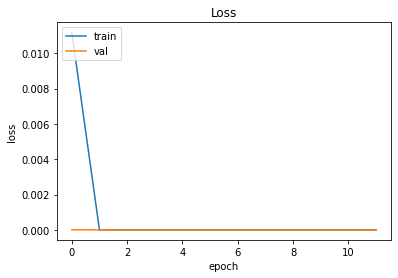

In [174]:
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<br>

In [175]:
results = model_LSTM.evaluate(x_test,  y_test, verbose=2)
print('spm acc:', round(results[1] * 100,2), '%' )

704/704 - 2s - loss: 1.2240e-08 - accuracy: 1.0000
spm acc: 100.0 %


<br>

#### 결과
SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy를 보임을 확인할 수 있다.